# Integrating `torchmil` with Graph Neural Networks (GNNs) frameworks

In this example, we will demonstrate how to use Graph Neural Network (GNN) libraries within the `torchmil` framework. As we will see, integration with popular GNN libraries is straightforward, allowing us to apply GNNs to tasks involving graph-structured data. Specifically, we will use the `torch_geometric` library, which is a popular choice for GNNs in PyTorch. 

Whole Slide Images (WSIs) can be represented as a graph where each node corresponds to a patch of the image, and edges can represent spatial relationships or other connections between these patches. In various `torchmil` datasets, the adjacency matrix of this graph is already provided, allowing us to leverage GNNs for tasks like classification or segmentation.

## The data

In this tutorial, we will use the PANDA dataset, a public dataset for the detection of prostate cancer. The original version of this dataset can be found [here](https://panda.grand-challenge.org/data/).

To load the data, we are going to follow the same approach as in the [WSI classification example](https://torchmil.readthedocs.io/en/latest/examples/WSI_classification.html). Take a look at that example for more details about the data loading process.

Let's start by taking a look at one WSI to understand the data we are working with. First, we define a function to read the patches of a WSI. 

In [36]:
import openslide
import cv2
import numpy as np
from tqdm import tqdm


def read_wsi_patches(wsi_path, coords_path, size=512, resize_size=10):
    slide = openslide.OpenSlide(wsi_path)

    inst_coords = np.load(coords_path, allow_pickle=True)
    bag_len = len(inst_coords)
    patches_list = []
    row_list = []
    column_list = []
    for i in tqdm(range(bag_len), desc="Reading patches"):
        coord = inst_coords[i]
        x, y = coord

        patch_pil = slide.read_region((x, y), 0, (size, size))
        patch = np.array(patch_pil)[:, :, :3]
        patch = cv2.resize(patch, (resize_size, resize_size))
        patches_list.append(patch)

        row = int(y / size)
        column = int(x / size)
        row_list.append(row)
        column_list.append(column)

    row_array = np.array(row_list)
    column_array = np.array(column_list)

    row_array = row_array - row_array.min()
    column_array = column_array - column_array.min()

    return patches_list, row_array, column_array

Next, we will load the WSI and visualize it using `matplotlib`. The patches will be displayed in a grid format, where each patch is represented as a small image.

Reading patches:   0%|          | 0/175 [00:00<?, ?it/s]

Reading patches: 100%|██████████| 175/175 [00:01<00:00, 104.49it/s]


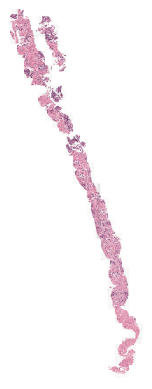

In [37]:
import os
from torchmil.visualize import patches_to_canvas
import matplotlib.pyplot as plt

img_dir = "/data/datasets/PANDA/PANDA_original/train_images/"
coord_dir = "/data/datasets/PANDA/PANDA_original/patches_512/coords/"

wsi_name = "ff9dd750be215c8ba38b5195de612253"

wsi_path = os.path.join(img_dir, wsi_name + ".tiff")
coords_path = os.path.join(coord_dir, wsi_name + ".npy")

patches_list, row_array, column_array = read_wsi_patches(
    wsi_path, coords_path, size=512, resize_size=10
)

canvas = patches_to_canvas(patches_list, row_array, column_array, 10)

plt.imshow(canvas)
plt.axis("off")
plt.show()

Great! Next, we will load the PANDA dataset.

In [38]:
import torch
from torchmil.datasets import PANDAMILDataset
from sklearn.model_selection import train_test_split

# suppress warnings
import warnings

warnings.filterwarnings("ignore")

root = "/home/fran/data/datasets/PANDA/PANDA_original/"
features = "UNI"
patch_size = 512

dataset = PANDAMILDataset(
    root=root,
    features=features,
    patch_size=patch_size,
    partition="train",
    load_at_init=True,
    bag_keys=["X", "Y", "adj"],
)

# Split the dataset into train and validation sets
bag_labels = dataset.get_bag_labels()
idx = list(range(len(bag_labels)))
val_prop = 0.2
idx_train, idx_val = train_test_split(
    idx, test_size=val_prop, random_state=1234, stratify=bag_labels
)
train_dataset = dataset.subset(idx_train)
val_dataset = dataset.subset(idx_val)

# Load the test dataset
test_dataset = PANDAMILDataset(
    root=root,
    features=features,
    patch_size=patch_size,
    partition="test",
    load_at_init=True,
    bag_keys=["X", "Y", "adj"],
)

Let's take a look at the data it returns:

In [39]:
# Print one bag
bag = train_dataset[0]
print("Bag type:", type(bag))
for key in bag.keys():
    print(key, bag[key].shape)
print("Adjacency matrix type:", type(bag["adj"]), bag["adj"].is_sparse)

Bag type: <class 'tensordict._td.TensorDict'>
X torch.Size([51, 1024])
Y torch.Size([])
adj torch.Size([51, 51])
Adjacency matrix type: <class 'torch.Tensor'> True


As you can see, the adjacency matrix is represented as a sparse matrix, which is a common format for representing graphs. 

## Mini-batching with torchmil vs torch_geometric

To allow mini-batching in `torchmil`, the `torchmil.data.collate_fn` function collates the the adjacency matrices into a single sparse tensor of shape `(batch_size, max_num_nodes, max_num_nodes)`. Frameworks like `torch_geometric` work differently, as adjacency are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), see the [PyTorch Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/advanced/batching.html). 

Thus, we cannot directly use the `torchmil` collate function with `torch_geometric` models. But don't worry, all we need to do is to modify the `collate_fn` to convert the adjacency matrices into the format expected by `torch_geometric`. This is what we do next.

In [58]:
from tensordict import TensorDict
from torch_geometric.data import Data, Batch


def collate_fn_graph(
    batch_list: list[dict[str, torch.Tensor]],
) -> TensorDict:
    # Convert each bag to a PyTorch Geometric Data object
    data_list = []
    for bag in batch_list:
        data = Data(x=bag["X"].float(), y=bag["Y"], adj=bag["adj"].float())
        data_list.append(data)

    # Create a batch from the list of Data objects
    batch = Batch.from_data_list(data_list)
    return TensorDict(
        {"X": batch.x, "Y": batch.y, "adj": batch.adj, "batch": batch.batch}
    )

In [59]:
batch_size = 16

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_graph
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_graph
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_graph
)


it = iter(train_dataloader)
batch = next(it)
print("Batch type:", type(batch))
for key in batch.keys():
    print(key, batch[key].shape)

Batch type: <class 'tensordict._td.TensorDict'>
X torch.Size([2368, 1024])
Y torch.Size([16])
adj torch.Size([2368, 2368])
batch torch.Size([2368])


Each batch is again a `TensorDict` with an additional key `batch` that indicates the batch index of each instance. This is useful for models that require knowledge of which instances belong to which batch, such as when using GNNs.

## Training a GNN model

Now, we define a simple GNN model using `torch_geometric`. This model will take the node features and the adjacency matrix as input and output a classification score for each graph. Note that each graph corresponds to a WSI in our dataset.

In [75]:
from torchmil.models import MILModel
from torch.nn import LayerNorm
from torch_geometric.nn import DeepGCNLayer, GCNConv
from torch_geometric.nn.pool import global_mean_pool


class GraphABMIL(MILModel):
    def __init__(self, in_dim, emb_dim, n_layers=4):
        super().__init__()

        # Feature extractor
        self.in_proj = torch.nn.Linear(in_dim, emb_dim)

        self.gcn_layers = torch.nn.ModuleList(
            [
                DeepGCNLayer(
                    GCNConv(emb_dim, emb_dim),
                    norm=LayerNorm(emb_dim),
                    dropout=0.2,
                    act=torch.nn.ReLU(),
                )
                for _ in range(n_layers)
            ]
        )

        self.classifier = torch.nn.Linear(emb_dim, 1)
        self.criterion = torch.nn.BCEWithLogitsLoss()

    def forward(self, X, adj, batch):
        # Project features
        X = self.in_proj(X)

        # Apply GCN layers
        for gcn_layer in self.gcn_layers:
            X = gcn_layer(X, adj)

        # Global pooling (mean)
        X = global_mean_pool(X, batch)

        # Classifier
        logits = self.classifier(X).squeeze(-1)

        return logits

    def compute_loss(self, Y, X, adj, batch):
        Y_pred = self.forward(X, adj, batch)

        crit_loss = self.criterion(Y_pred.float(), Y.float())
        crit_name = self.criterion.__class__.__name__

        return Y_pred, {crit_name: crit_loss}

    def predict(self, X, adj, batch, return_inst_pred=False):
        Y_pred = self.forward(X, adj, batch)

        if return_inst_pred:
            return Y_pred, None

        return Y_pred


model = GraphABMIL(in_dim=1024, emb_dim=256)
print(model)

GraphABMIL(
  (in_proj): Linear(in_features=1024, out_features=256, bias=True)
  (gcn_layers): ModuleList(
    (0-3): 4 x DeepGCNLayer(block=res+)
  )
  (classifier): Linear(in_features=256, out_features=1, bias=True)
  (criterion): BCEWithLogitsLoss()
)


In [76]:
from torchmil.utils.trainer import Trainer
import torchmetrics

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainer = Trainer(
    model=model,
    optimizer=optimizer,
    metrics_dict={"acc": torchmetrics.Accuracy(task="binary").to(device)},
    obj_metric="acc",
    device=device,
    disable_pbar=False,
    verbose=False,
)

In [77]:
EPOCHS = 10
trainer.train(
    max_epochs=EPOCHS, train_dataloader=train_dataloader, val_dataloader=val_dataloader
)

[Epoch 10] Validation : 100%|██████████| 111/111 [00:01<00:00, 108.84it/s, val/loss=0.143, val/BCEWithLogitsLoss=0.143, val/acc=0.954]


## Evaluating the model

Let's evaluate the model. We are going to compute the accuracy and f1-score on the test set. The accuracy is the proportion of correctly classified bags, while the f1-score is the harmonic mean of precision and recall. The f1-score is a good metric for imbalanced datasets.
Typically, in MIL datasets, there are more negative bags than positive bags.

In [80]:
from sklearn.metrics import accuracy_score, f1_score

inst_pred_list = []
y_inst_list = []
Y_pred_list = []
Y_list = []

model = model.to(device)
model.eval()

for batch in test_dataloader:
    batch = batch.to(device)

    X = batch["X"].to(device)
    adj = batch["adj"].to(device)
    Y = batch["Y"]
    batch_idx = batch["batch"].to(device)

    # predict bag label using our model
    out = model(X, adj, batch=batch_idx)
    Y_pred = (out > 0).float()

    Y_pred_list.append(Y_pred)
    Y_list.append(Y)

Y_pred = torch.cat(Y_pred_list).cpu().numpy()
Y = torch.cat(Y_list).cpu().numpy()

print(f"test/bag/acc: {accuracy_score(Y_pred, Y)}")
print(f"test/bag/f1: {f1_score(Y_pred, Y)}")

test/bag/acc: 0.9437012263099219
test/bag/f1: 0.9605622803592346


Excellent! Our model has reached a very high accuracy and f1-score in only 10 epochs!